<h1>2. Applying InceptionNet pre-trained model </h1>

* We will not include the top layer of InceptionNet model.
* Instead of top layer, we will add a dense layer with four units and with softmax activation function.
* We will take the imagenet weight as weight initialization and will not freeze any layer.

In [2]:
import matplotlib.pyplot as plt
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
labels = os.listdir('../input/oct2017/OCT2017 /train/')
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                                   validation_split=0.2)


In [4]:
IMG_SIZE = 224
batch_size = 16
train_data_dir = '../input/oct2017/OCT2017 /train'
validation_data_dir = '../input/oct2017/OCT2017 /val'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='training',
    class_mode='categorical')
valid_X, valid_Y = next(train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=4000,
    subset='validation',
    class_mode='categorical'))

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


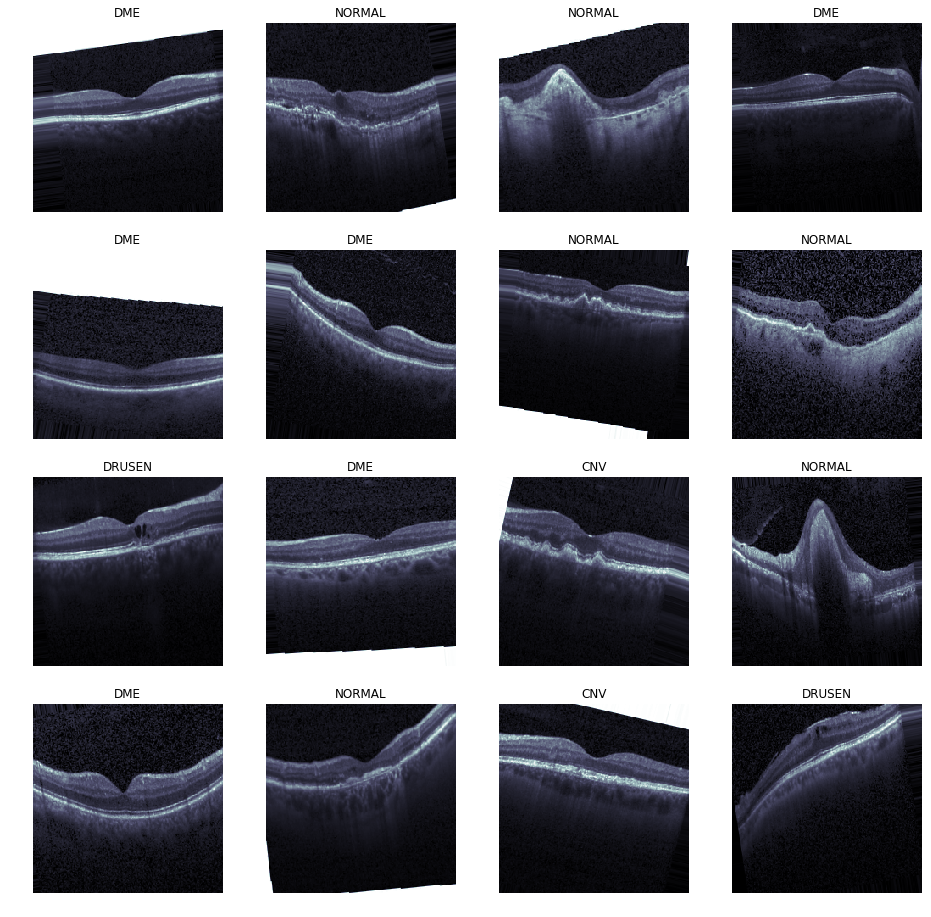

In [5]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

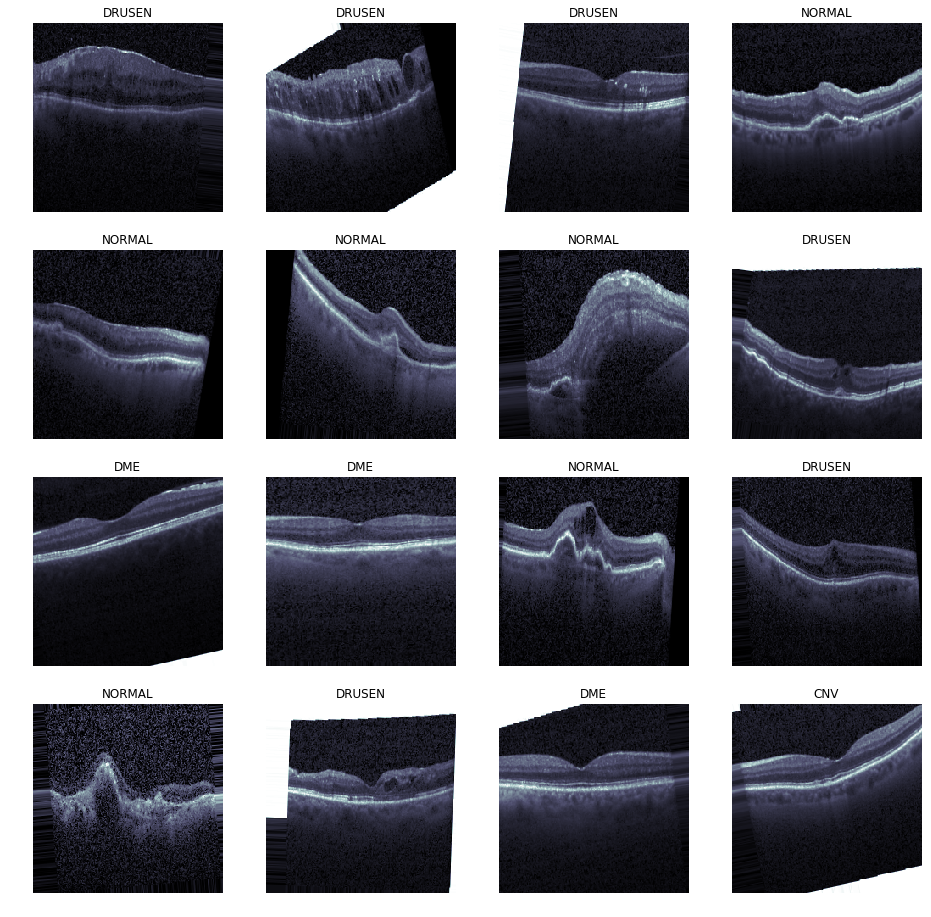

In [7]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [8]:
# defining inceptionnet model
def inception_v3():
    img_in = Input(t_x.shape[1:])              #input of model 
    model =  InceptionV3(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 
    x = model.output  
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [9]:
# compiling model
model = inception_v3()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [10]:
# creating checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
# training model
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=100,
                                  validation_data = (valid_X,valid_Y), 
                                  epochs = 30,
                                  callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 95s 947ms/step - loss: 0.8848 - acc: 0.7006 - val_loss: 4.5836 - val_acc: 0.6212

Epoch 00001: val_acc improved from -inf to 0.62125, saving model to weights.best.hdf5
Epoch 2/30
100/100 [==============================] - 74s 742ms/step - loss: 0.5683 - acc: 0.7969 - val_loss: 1.8330 - val_acc: 0.6655

Epoch 00002: val_acc improved from 0.62125 to 0.66550, saving model to weights.best.hdf5
Epoch 3/30
100/100 [==============================] - 74s 743ms/step - loss: 0.5123 - acc: 0.8275 - val_loss: 4.9948 - val_acc: 0.3020

Epoch 00003: val_acc did not improve from 0.66550
Epoch 4/30
100/100 [==============================] - 74s 739ms/step - loss: 0.4659 - acc: 0.8494 - val_loss: 1.0380 - val_acc: 0.5597

Epoch 00004: val_acc did not improve from 0.66550
Epoch 5/30
100/100 [==============================] - 74s 741ms/step - loss: 0.4159 - acc: 0.8637 - val_loss: 2.2816 - val_acc: 0.7348

Epoch 00005: val_acc improved from 0.66550 to

In [12]:
# creating test data
test_X, test_Y = next(train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=8000,
    subset='validation',
    class_mode='categorical'))

Found 16696 images belonging to 4 classes.


In [13]:
# loading the model with best weight
model = inception_v3()
model.load_weights(filepath)

In [14]:
# predicting y value
y_pred = model.predict(test_X)

In [15]:
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

In [16]:
actual_class = []
for i in range(len(test_Y)):
    actual_class.append(np.argmax(test_Y[i]))

In [18]:
# accuracy score
print('accuracy = ',accuracy_score(pred_class,actual_class))

accuracy =  0.927375


In [21]:
# defining confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


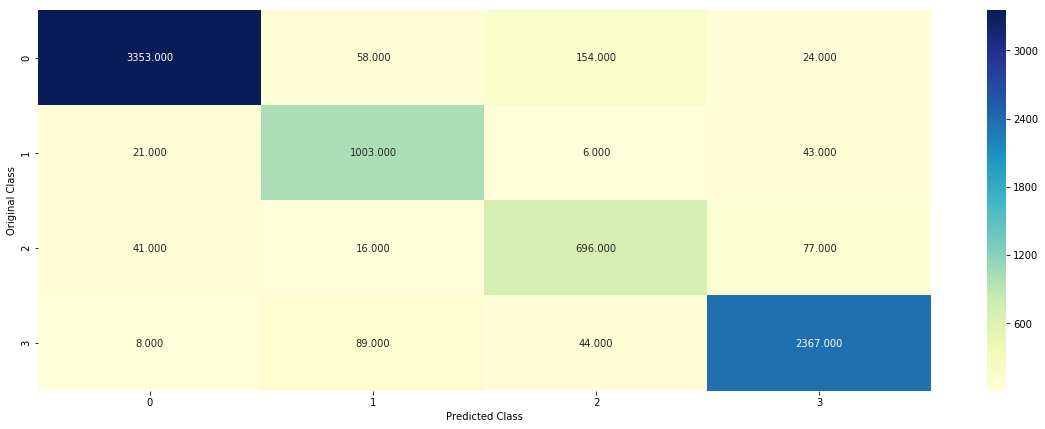

-------------------- Precision matrix (Columm Sum=1) --------------------


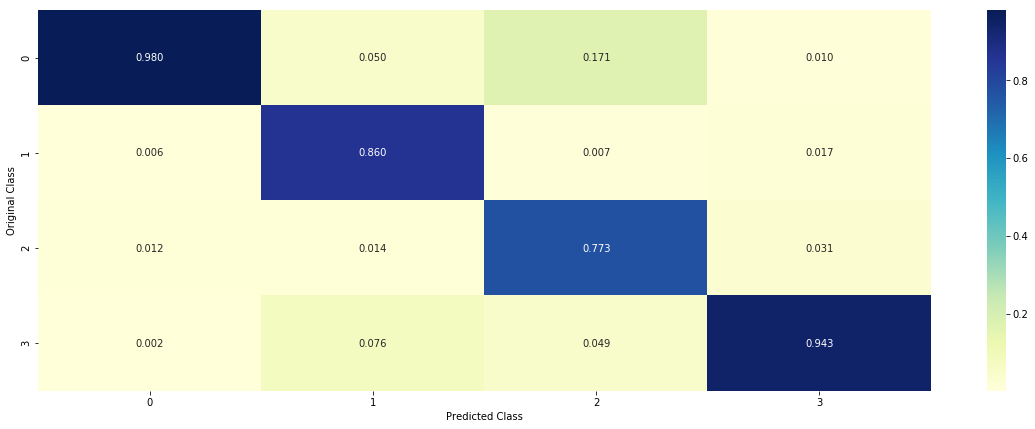

-------------------- Recall matrix (Row sum=1) --------------------


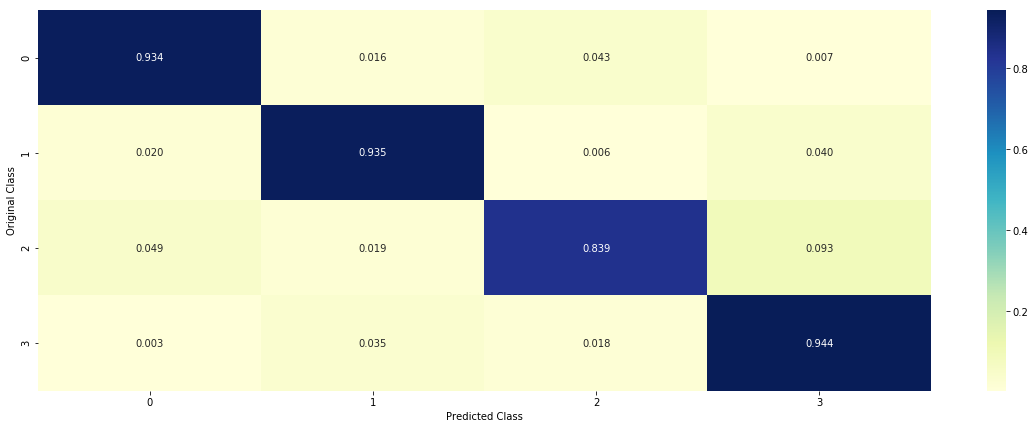

In [22]:
plot_confusion_matrix(actual_class,pred_class)